In [19]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/AI-Advanced-Course')

In [20]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/AI-Advanced-Course-master')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import imp
try:
    imp.find_module('jupyterplot')
    from jupyterplot import ProgressPlot
except ImportError:
    !pip install jupyterplot
    from jupyterplot import ProgressPlot

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets as D
from torchvision import transforms as T
from torchvision.models import resnet

from utils import invest_size
from utils import train_step, test_step
from utils import get_cifar10_dataset, make_dataloader
from utils import simulate_scheduler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# VGG

In [22]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=10):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
}

def vgg11():
    return VGG(make_layers(cfg['vgg11']))

def vgg16():
    return VGG(make_layers(cfg['vgg16']))

def vgg11_bn():
    return VGG(make_layers(cfg['vgg11'], batch_norm=True))

def vgg16_bn():
    return VGG(make_layers(cfg['vgg16'], batch_norm=True))

# VGG11

In [23]:
print(vgg11())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# VGG16

In [24]:
print(vgg16())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# VGG11 + Batch Normalization

In [25]:
print(vgg11_bn())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

# VGG16 + Batch Normalization

In [26]:
print(vgg16_bn())

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# ResNet Blocks

In [27]:
downsample = nn.Sequential(nn.Conv2d(16, 32, 1, 2), nn.BatchNorm2d(32))

# Basic Block - for ResNet18, Resnet34

In [28]:
print(f'{" Without stride ":=^80}')
invest_size(torch.randn(1, 16, 32, 32), resnet.BasicBlock(16, 16))
print()
print(f'{" With stride ":=^80}')
invest_size(torch.randn(1, 16, 32, 32), resnet.BasicBlock(16, 32, stride=2, downsample=downsample))

================================ Without stride ================================
                             input shape                              
                     torch.Size([1, 16, 32, 32])                      
                                  |                                   
                                  V                                   
                                layer                                 
BasicBlock(
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
                                  |                                   
                                  V                                   
                       

# Bottleneck Block - for ResNet50 ~

In [29]:
print(f'{" Without stride ":=^80}')
invest_size(torch.randn(1, 16, 32, 32), resnet.Bottleneck(16, 16//4))
print()
print(f'{" With stride ":=^80}')
invest_size(torch.randn(1, 16, 32, 32), resnet.Bottleneck(16, 32//4, stride=2, downsample=downsample))

================================ Without stride ================================
                             input shape                              
                     torch.Size([1, 16, 32, 32])                      
                                  |                                   
                                  V                                   
                                layer                                 
Bottleneck(
  (conv1): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)
                         

In [30]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu'
                )
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        for m in self.modules():
            if isinstance(m, resnet.Bottleneck):
                nn.init.constant_(m.bn3.weight, 0)
            elif isinstance(m, resnet.BasicBlock):
                nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                resnet.conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, norm_layer=norm_layer)
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.flatten(1)
        
        x = self.fc(x)
        return x

def resnet18():
    return ResNet(resnet.BasicBlock, [2, 2, 2, 2])

def resnet50():
    return ResNet(resnet.Bottleneck, [3, 4, 6, 3])

# ResNet18

In [31]:
print(resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

# ResNet50

In [13]:
print(resnet50())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

Files already downloaded and verified


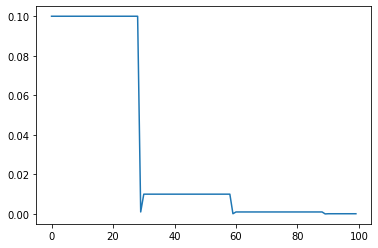

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
momentum = 0.9
phases = ['train', 'test']

num_epochs = 100
learning_rate = 0.1
batch_size = 128

data_augmentation = True

dataset = get_cifar10_dataset(random_crop=data_augmentation)
loader = make_dataloader(dataset, batch_size)

lrs = simulate_scheduler(0.1, 100, torch.optim.lr_scheduler.StepLR, step_size=30)
plt.plot(lrs)

In [18]:
# model = vgg11()
# model = vgg16()
# model = vgg11_bn()
# model = vgg16_bn()
# model = resnet18()
# model = resnet50()
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), learning_rate, 0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30)

pp = ProgressPlot(
    plot_names=phases,
    line_names=['loss', 'accuracy'],
    x_lim=[0, None],
    x_label='Iteration',
    y_lim=[[0, None], [0, 100]]
)

accuracy = 0
pbar = tqdm(total=(len(loader['train']) + len(loader['test'])) * num_epochs)
for epoch in range(num_epochs):
    for inputs, target in loader['train']:
        loss = train_step(model, inputs, target, optimizer, criterion, device)
        pp.update([[loss, -1], [-500, accuracy]])
        pbar.update()
    
    corrects = 0
    for inputs, target in loader['test']:
        output, _ = test_step(model, inputs, target, device=device)
        corrects += (output.argmax(1).cpu() == target).sum().item()
        pbar.update()
    accuracy = corrects / len(dataset['test']) * 100
    
    print(f'Epoch: {epoch+1} accuracy {accuracy:.2f}')
    scheduler.step()
pbar.close()
pp.finalize()

### model save ###
# torch.save(model.cpu().state_dict(), 'path/to/save')
### model load ###
# model.load_state_dict(torch.load('path/to/save'))

NameError: ignored